In [1]:
!apt install -qq graphviz graphviz-dev
!pip install -qqq huggingface_hub pygraphviz --progress-bar off

graphviz is already the newest version (2.42.2-6).
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import sys
from huggingface_hub import ModelCard, HfApi, RepoCard
import requests
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict
from networkx.drawing.nx_agraph import graphviz_layout
from IPython.display import clear_output

In [3]:
# We should first try to cache models
class CachedModelCard(ModelCard):
  _cache = {}

  @classmethod
  def load(cls, model_id: str, **kwargs) -> "ModelCard":
    if model_id not in cls._cache:
      try:
        print('REQUEST ModelCard:', model_id)
        cls._cache[model_id] = super().load(model_id, **kwargs)
      except:
        cls._cache[model_id] = None
    else:
      print('CACHED:', model_id)
    return cls._cache[model_id]

In [4]:
def get_model_names_from_yaml(url):
    """Get a list of parent model names from the yaml file."""
    model_tags = []
    response = requests.get(url)
    if response.status_code == 200:
        model_tags.extend([item for item in response.content if '/' in str(item)])
    return model_tags

In [5]:
def get_license_color(model):
    """Get the color of the model based on its license."""
    try:
        card = CachedModelCard.load(model)
        license = card.data.to_dict()['license'].lower()
        # Define permissive licenses
        permissive_licenses = ['mit', 'bsd', 'apache-2.0', 'openrail']  # Add more as needed
        # Check license type
        if any(perm_license in license for perm_license in permissive_licenses):
            return 'lightgreen'  # Permissive licenses
        else:
            return 'lightcoral'  # Noncommercial or other licenses
    except Exception as e:
        print(f"Error retrieving license for {model}: {e}")
        return 'lightgray'

In [6]:
def get_model_names(model, genealogy, found_models=None, visited_models=None):
    print('---')
    print(model)
    if found_models is None:
        found_models = set()
    if visited_models is None:
        visited_models = set()

    if model in visited_models:
        print("Model already visited...")
        return found_models
    visited_models.add(model)

    try:
        card = CachedModelCard.load(model)
        card_dict = card.data.to_dict()
        license = card_dict['license']

        model_tags = []
        if 'base_model' in card_dict:
            model_tags = card_dict['base_model']

        if 'tags' in card_dict and not model_tags:
            tags = card_dict['tags']
            model_tags = [model_name for model_name in tags if '/' in model_name]

        if not model_tags:
            model_tags.extend(get_model_names_from_yaml(f"https://huggingface.co/{model}/blob/main/merge.yml"))
        if not model_tags:
            model_tags.extend(get_model_names_from_yaml(f"https://huggingface.co/{model}/blob/main/mergekit_config.yml"))

        if not isinstance(model_tags, list):
            model_tags = [model_tags] if model_tags else []

        found_models.add(model)

        for model_tag in model_tags:
            genealogy[model_tag].append(model)
            get_model_names(model_tag, genealogy, found_models, visited_models)

    except Exception as e:
        print(f"Could not find model names for {model}: {e}")

    return found_models

In [7]:
def find_root_nodes(G):
    """ Find all nodes in the graph with no predecessors """
    return [n for n, d in G.in_degree() if d == 0]

In [8]:
def max_width_of_tree(G):
    """ Calculate the maximum width of the tree """
    max_width = 0
    for root in find_root_nodes(G):
        width_at_depth = calculate_width_at_depth(G, root)
        local_max_width = max(width_at_depth.values())
        max_width = max(max_width, local_max_width)
    return max_width

In [9]:
def calculate_width_at_depth(G, root):
    """ Calculate width at each depth starting from a given root """
    depth_count = defaultdict(int)
    queue = [(root, 0)]
    while queue:
        node, depth = queue.pop(0)
        depth_count[depth] += 1
        for child in G.successors(node):
            queue.append((child, depth + 1))
    return depth_count

In [10]:
def create_family_tree(start_model):
    genealogy = defaultdict(list)
    get_model_names(start_model, genealogy)  # Assuming this populates the genealogy

    print("Number of models:", len(CachedModelCard._cache))

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for parent, children in genealogy.items():
        for child in children:
            G.add_edge(parent, child)

    try:
        # Get max depth and width
        max_depth = nx.dag_longest_path_length(G) + 1
        max_width = max_width_of_tree(G) + 1
    except:
        # Get max depth and width
        max_depth = 21
        max_width = 9

    # Estimate plot size
    height = max(8, 1.6 * max_depth)
    width = max(8, 6 * max_width)

    # Set Graphviz layout attributes for a bottom-up tree
    plt.figure(figsize=(width, height))
    pos = graphviz_layout(G, prog="dot")

    # Determine node colors based on license
    node_colors = [get_license_color(node) for node in G.nodes()]
    clear_output()

    # Create a label mapping with line breaks
    labels = {node: node.replace("/", "\n") for node in G.nodes()}

    # Draw the graph
    nx.draw(G, pos, labels=labels, with_labels=True, node_color=node_colors, font_size=12, node_size=8_000, edge_color='black')

    # Create a legend for the colors
    legend_elements = [
        Patch(facecolor='lightgreen', label='Permissive'),
        Patch(facecolor='lightcoral', label='Noncommercial'),
        Patch(facecolor='lightgray', label='Unknown')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.title(f"{start_model}'s Family Tree", fontsize=20)
    plt.show()

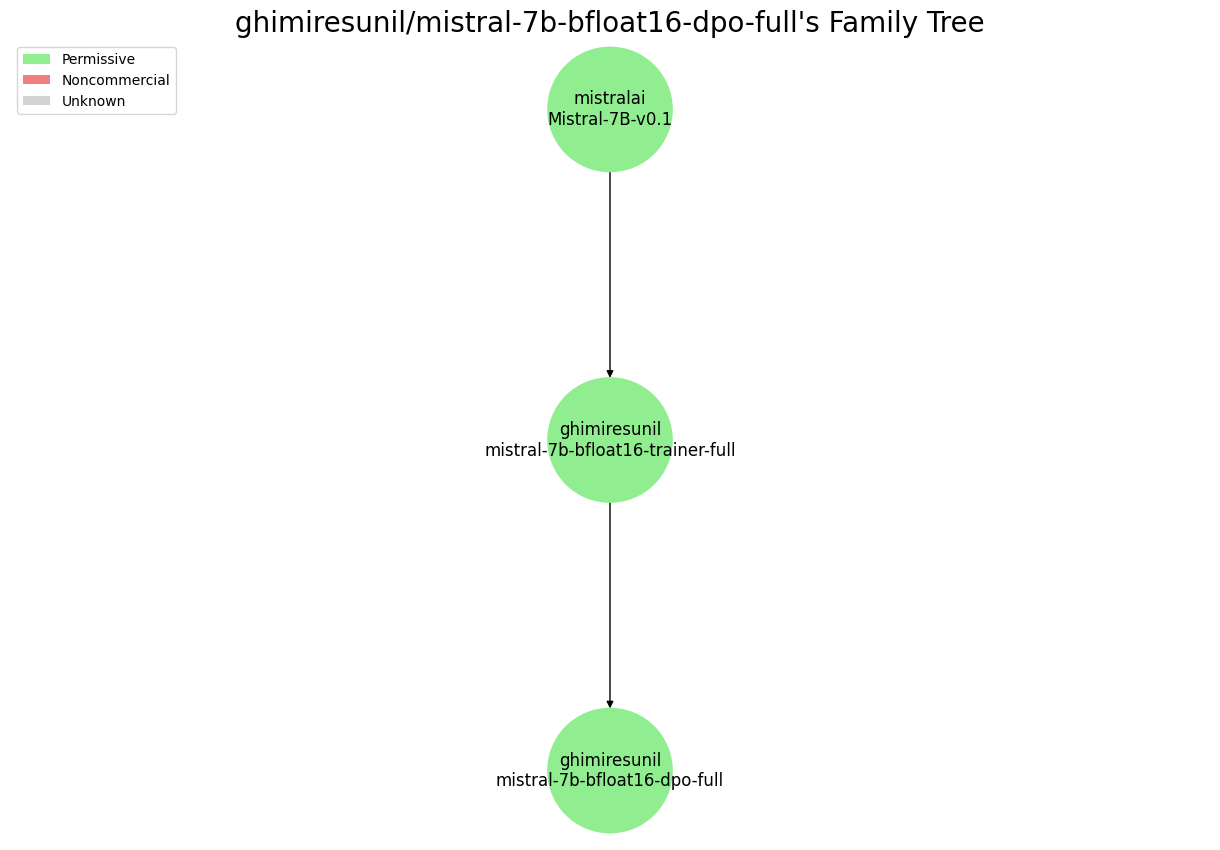

In [11]:
# @title # 🌳 Model Family Tree
# @markdown Automatically calculate the <strong>family tree of a given model</strong>. It also displays the type of license each model uses (permissive, noncommercial, or unknown). Special thanks to [leonardlin](https://huggingface.co/leonardlin) for his caching implementation.

MODEL_ID = "ghimiresunil/mistral-7b-bfloat16-dpo-full" # @param {type:"string"}
create_family_tree(MODEL_ID)